In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from scipy import stats
from scipy.stats import linregress

fontsize = 14
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
legend_size =14
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 24}

plt.rc('font', **font)
params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sns.set_style('white')
sns.set_context('paper')
sns.set()

# Load Data

In [2]:
dataset = 'sleep'
gamma = 3

if dataset == 'seer':
    time = 'months'    
else:  
    time = 'days'

data_path = 'analysis/{}/'.format(dataset)
empirical = np.load(data_path + "Test_empirical_t.npy")
event  = np.load(data_path + "Test_empirical_e.npy")
print("data_path: ", data_path)
print("event: ", event.shape)
print("empirical: ", empirical.shape)
print("EVENT RATE: ", np.sum(event)/len(event))
assert(len(event) == len(empirical))

t_empirical_range = np.unique(np.sort(np.append(empirical, [0])))

data_path:  analysis/sleep/
event:  (503,)
empirical:  (503,)
EVENT RATE:  0.24254473161033796


In [3]:
# load observed & censored
sca = np.load(data_path + 'sca/gamma_{}/Test_predicted_t_samples.npy'.format(gamma))

print (sca.shape)



(200, 503)


In [4]:
predicted_samples_sca  = np.transpose(sca)
print("predicted_samples_sca: ", predicted_samples_sca.shape)


predicted_samples_sca:  (503, 200)


## CI Index

In [5]:
def ci_index(predicted_event_times, event, event_times):
    return concordance_index(event_times=event_times, predicted_event_times=predicted_event_times.tolist(),
                                     event_observed=event)
print("SCA CI INDEX: ", ci_index(np.median(predicted_samples_sca, axis=1), 
                                 event=event,
                                 event_times=empirical))


SCA CI INDEX:  0.7498264668653791


## RAE 

In [6]:
# Relative absolute Error from MTLR
def MTLR_RAE(pred_samp, emp_t_i, cens_t):
    constant = 1e-8
    pred_t_i = np.median(pred_samp, axis=1)
    abs_error_i = np.abs(pred_t_i -emp_t_i)
    pred_great_empirical = pred_t_i > emp_t_i
    min_rea_i = np.minimum(np.divide(abs_error_i, emp_t_i + 1e-8), 1.0)
    idx_cond = np.logical_and(cens_t, pred_great_empirical)
    min_rea_i[idx_cond] = 0.0
    
    return np.sum(min_rea_i)/ len(emp_t_i)

In [7]:
def print_rae(samples, method):
    observed = event ==1
    rae = MTLR_RAE(pred_samp=samples[observed], emp_t_i=empirical[observed], cens_t=1-event[observed])
    print(method, rae)

In [8]:
print_rae(predicted_samples_sca, "SCA RAE Observed")

SCA RAE Observed 0.5423789693409443


In [9]:
def print_rae(samples, method):
    censored = event == 0
    rae = MTLR_RAE(pred_samp=samples[censored], emp_t_i=empirical[censored], cens_t=1-event[censored])
    print(method, rae)

In [10]:
print_rae(predicted_samples_sca, "SCA RAE Censored")

SCA RAE Censored 0.2244014265485046


,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,503,503
9.0,1,1,0,0,503
23.0,1,1,0,0,502
64.0,1,1,0,0,501
74.0,1,1,0,0,500
...,...,...,...,...,...
5351.0,1,0,1,0,5
5366.0,1,0,1,0,4
5467.0,1,0,1,0,3


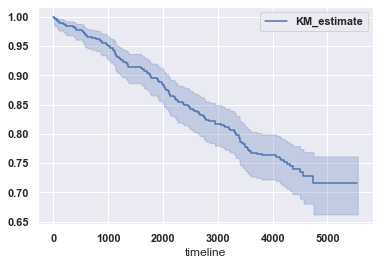

In [11]:
# 
kmf = KaplanMeierFitter()
kmf.fit(empirical, event_observed=event)  
kmf.median_
kmf.plot()
kmf.event_table

In [12]:
range_quant = np.arange(start=0, stop=1.010, step=0.010)
t_empirical_range = np.unique(np.sort(np.append(empirical, [0])))
km_pred_alive_prob = [kmf.predict(i) for i in t_empirical_range]
empirical_dead = 1 - np.array(km_pred_alive_prob)
#print("empirical_dead: ", empirical_dead, "size: ", len(empirical_dead))

In [13]:
# Bounds
def ci_bounds(surv_t,cumulative_sq_,  alpha=0.95):
    #print("surv_t: ", surv_t, "cumulative_sq_: ", cumulative_sq_)
    # This method calculates confidence intervals using the exponential Greenwood formula.
    # See https://www.math.wustl.edu/%7Esawyer/handouts/greenwood.pdf
    #alpha = 0.95 
    if surv_t > 0.999:
        surv_t = 1
        cumulative_sq_ = 0
    alpha = 0.95
    constant = 1e-8
    alpha2 = stats.norm.ppf((1. + alpha) / 2.)
    v = np.log(surv_t)
    left_ci = np.log(-v)
    right_ci = alpha2 * np.sqrt(cumulative_sq_) * 1/v

    c_plus = left_ci + right_ci
    c_neg = left_ci - right_ci
    
    ci_lower = np.exp(-np.exp(c_plus))
    ci_upper = np.exp(-np.exp(c_neg))
       
    return [ci_lower, ci_upper]

In [14]:
 #Population wise cdf 
def compute_km_dist(predicted_samples, t_empirical_range, observed=None):
    km_dead = []
    km_surv = 1
    
    km_var = []
    km_ci = []
    km_sum = 0
    
    kernel = []
    e_event = event
    
    if observed:
        predicted_samples = predicted_samples[event==1]
        e_event = e_event[event_test==1]
        
            
    for j in np.arange(len(t_empirical_range)):
        r = t_empirical_range[j]
        low = 0 if j ==0 else t_empirical_range[j-1]
        area = 0
        censored = 0
        dead = 0
        at_risk = len(predicted_samples)
        count_death = 0
        for i in np.arange(len(predicted_samples)):
            e = e_event[i]
            if len(kernel)!= len(predicted_samples):
                kernel_i = stats.gaussian_kde(predicted_samples[i]) 
                kernel.append(kernel_i)
            else:
                kernel_i = kernel[i]
            at_risk = at_risk - kernel_i.integrate_box_1d(low=0, high=low)
            
            if e == 1:
                count_death+= kernel_i.integrate_box_1d(low=low, high=r)
        if at_risk == 0:
            break
        km_int_surv = 1 - count_death/at_risk
        km_int_sum = count_death / (at_risk * (at_risk - count_death))
        
        km_surv = km_surv * km_int_surv
        km_sum = km_sum + km_int_sum
        
        km_ci.append(ci_bounds(cumulative_sq_=km_sum, surv_t=km_surv))
    
    
        km_dead.append(1-km_surv)
        km_var.append(km_surv * km_surv * km_sum)
      
    return np.array(km_dead), np.array(km_var), np.array(km_ci)

In [15]:
#
km_dead_dist_sca, km_var_dist_sca, km_dist_ci_sca = compute_km_dist(predicted_samples_sca, 
                                                                    t_empirical_range=t_empirical_range)


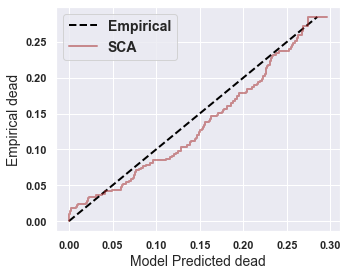

In [16]:
plt.figure(figsize=(5,4))
plt.plot(np.array(empirical_dead),np.array(empirical_dead), '--', color='black', lw=2, label='Empirical')
plt.step(x=np.array(km_dead_dist_sca), y=np.array(empirical_dead), label='SCA', color='brown', lw=2, alpha=0.5)
plt.xlabel('Model Predicted dead',  fontsize=fontsize)
plt.ylabel('Empirical dead',  fontsize=fontsize)
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)

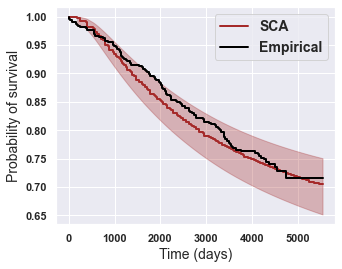

<Figure size 432x288 with 0 Axes>

In [17]:
fig=plt.figure(figsize=(5,4))
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Probability of survival",  fontsize=fontsize)


plt.step(x = t_empirical_range, y = 1-km_dead_dist_sca, label='SCA', color='brown', lw=2)
plt.fill_between( t_empirical_range, km_dist_ci_sca[:, 0], km_dist_ci_sca[:, 1], 
                 alpha=0.3, color='brown', linestyle="-", linewidth=1)

    
plt.step(x = t_empirical_range, y = 1-empirical_dead, label='Empirical', color='black', lw=2)
plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()

In [18]:
# calibration slope
def print_cal(predicted, model):
    slope, intercept, r_value, p_value, std_err = linregress(x=predicted, y=empirical_dead)
    print( model, "slope: ", slope, "intercept: ", intercept, "p_value: ", p_value, "std_err: ", std_err)
    

In [19]:
print_cal(km_dead_dist_sca, "SCA Calibration")

SCA Calibration slope:  1.0223155101291994 intercept:  -0.013886760654121394 p_value:  0.0 std_err:  0.006076941106039274
